### Import libraries 

In [8]:
import cv2 as OpenCV
import numpy as np
import os
from matplotlib import pyplot as plt

### Helper functions


In [9]:
def displayImage(image, title = None):
    if image.ndim == 2:
        plt.gray()
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()

# OpenCV use BGR format for reading images as it's default 
# to get RGB images we need to change the format 
def readImageRGB(imagePath):
    return OpenCV.cvtColor(OpenCV.imread(imagePath), OpenCV.COLOR_BGR2RGB)

def RGBtoGRAY(images):
    grayImages = []
    for image in images: 
        grayImages.append(OpenCV.cvtColor(image, OpenCV.COLOR_RGB2GRAY))
    return grayImages

### Read all images from file into an array: images

In [10]:
def readImages(folderPath):
    files = sorted(os.listdir(folderPath))
    images = []
    for file in files:
    # Read only images of format jpg
        if ".jpg" in file:
            images.append(readImageRGB(folderPath + "/" + file))
    return images

images = readImages("Images")


### Get gray images

In [11]:
grayImages = RGBtoGRAY(images)

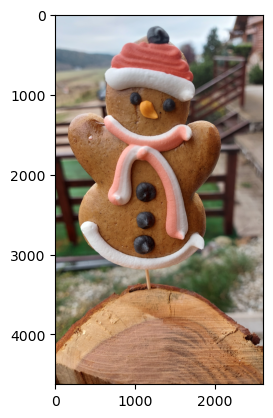

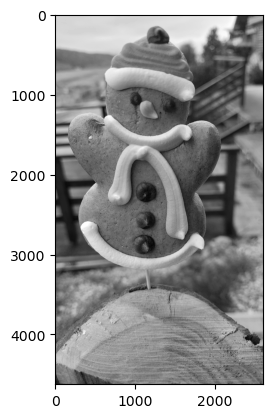

In [12]:
displayImage(images[0])
displayImage(grayImages[0])

### Get **SIFT** keypoints & descriptors on single image

In [13]:
SIFT = OpenCV.SIFT_create()

def getSiftKeypoints(imageIndex):
    keyPoint, descriptor = SIFT.detectAndCompute(grayImages[imageIndex], None)
    return keyPoint, descriptor

### Get **MSER** keypoints & descriptors on all images

In [36]:
MSER = OpenCV.MSER_create()

def getMserKeypoints(imageIndex):
    keyPoint = MSER.detect(grayImages[imageIndex], None)
    descriptor = MSER.compute(grayImages[imageIndex], keyPoint)
    return keyPoint, descriptor

### Draw the keypoints 

In [43]:
def drawKeypoints(images, grayImages, keyPoints, method = "SIFT"):
    for i in range(len(images)):
        img = OpenCV.drawKeypoints(grayImages[i], keyPoints[i], images[i], flags = OpenCV.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
        OpenCV.imwrite("keyPoints/"+method+"/"+str(i)+".jpg", img)

### Get keypoints & descriptors for all images

In [14]:
def getAllImagesKeyPoints (images, method = "SIFT"):
    keyPoints = []
    descriptors = []
    for i in range(0,len(images)):
        if method == "SIFT":
            keyPoint, descriptor = getSiftKeypoints(i)
        elif method == "MSER":
            keyPoint, descriptor = getMserKeypoints(i)
        keyPoints.append(np.array(keyPoint))
        descriptors.append(np.array(descriptor))
    return keyPoints, descriptors


### SIFT keypoints & descriptors on all images

In [17]:
SkeyPoints, Sdescriptors = getAllImagesKeyPoints(images, "SIFT")


### ⛔️ MSER keypoints & descriptors on all images
still have error in this part (most likely due to the gpu type used )
try to run it on a different machine

In [ ]:
MkeyPoints, Mdescriptors = getAllImagesKeyPoints(images, "MSER")


### Draw keypoints for all images (SIFT)

In [44]:
if (not os.path.exists("keyPoints")):
    os.mkdir("keyPoints")
if (not os.path.exists("keyPoints/SIFT")):
    os.mkdir("keyPoints/SIFT")

drawKeypoints(images, grayImages, SkeyPoints, "SIFT")

### ⛔️ Draw keypoints for all images (MSER)


In [45]:
if (not os.path.exists("keyPoints")):
    os.mkdir("keyPoints")
if (not os.path.exists("keyPoints/MSER")):
    os.mkdir("keyPoints/MSER")

# drawKeypoints(images, grayImages, MkeyPoints, "MSER")

## Image Matching

In [64]:
allDescriptors = []
for descriptors in Sdescriptors:
    for descriptor in descriptors:
        allDescriptors.append(descriptor)


allDescriptors = np.stack(allDescriptors)

### Create clusters from descriptors using **Kmeans** 


In [ ]:
from scipy.cluster.vq import kmeans

clusters = 400
iter = 2
centroids, variance = kmeans(allDescriptors, clusters, iter)

### Save the centroids for later use intstead of training multiple times


In [42]:
import joblib
joblib.dump((clusters,centroids), "centroids.pkl", compress = 3)

['centroids.pkl']

### Load the file that stores the centroids


In [66]:
import joblib
clusters, centroids = joblib.load("centroids.pkl")

### Create the visualWords 
⛔️ Make sure to run **getSiftKeypoints** first

In [44]:
from scipy.cluster.vq import vq

visualWords = []
for descriptors in Sdescriptors:
    words, _ = vq(descriptors, centroids)
    visualWords.append(words)

### Calculate the frequency of each word

In [45]:
frequency_vectors = []
for img_words in visualWords:
    histogram = np.zeros(clusters)
    for word in img_words:
        histogram[word] += 1
    frequency_vectors.append(histogram)

frequency_vectors = np.stack(frequency_vectors)

### Plot the frequency of words

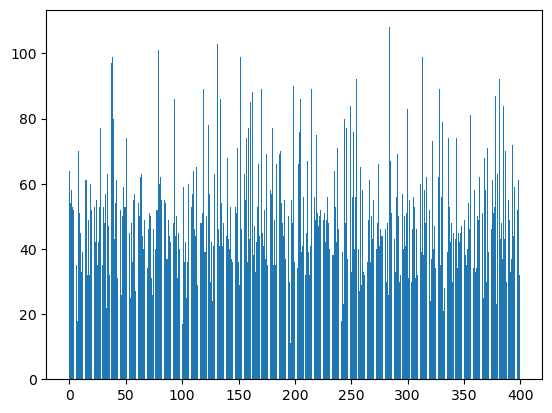

In [46]:
plt.bar(list(range(clusters)), frequency_vectors[100])
plt.show()

### **TFIDF**: get the visual words that does that most effect

In [47]:
n = len(images)

df = np.sum(frequency_vectors > 0, axis = 0)
idf = np.log(n/df)
tfidf = frequency_vectors * idf

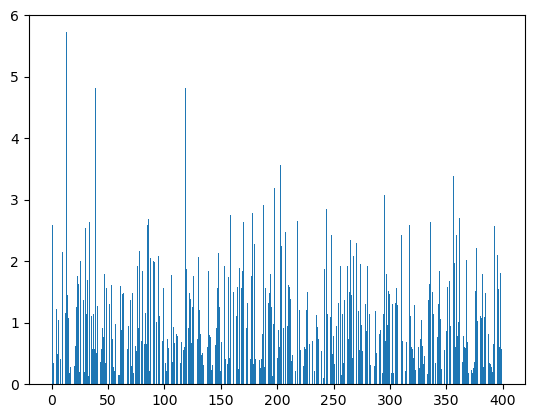

In [48]:
plt.bar(list(range(clusters)), tfidf[100])
plt.show()

### Scoring and searching for image matches

In [68]:
from numpy.linalg import norm
b = tfidf
def search(i: int, top_clusters: int = 5):

    # print("Search image:")
    # # show the search image
    # plt.imshow(images[i], cmap='gray')
    # plt.show()
    # print("-----------------------------------------------------")
    
    a = tfidf[i]
    cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
    idx = np.argsort(-cosine_similarity)[:top_clusters]
    # display the results
    return idx

### Get the best 30 matches for all images

In [70]:
matchesIDs = [search(i, 30) for i in range(len(images)) ]